In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)
BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34
og_directory = os.getcwd()



def allan_errors(frac_frequencies, allan_dev, tau, ramsey_time, dead_time,
                     method="oadev", noise_process="whitefm"):

        #Getting our common varibles needed
        n = len(frac_frequencies)
        m = tau/(ramsey_time+dead_time)      
        
        #Calculate edf for chi-squared calculation based on noise process
        if method == "oadev":
            if noise_process == "whitepm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            elif noise_process == "whitefm":
                edf = (4*m**4/(4*m**2+5))*(3*(n-1)/(2*m) - 2*(n-2)/n)
            else:
                print("Unable to calculate error for given error type")
                
        if method == "totdev":
            if noise_process == "whitepm" or noise_process=="whitefm":
                b = 1.50
                c= 0.0
                big_t = len(frac_frequencies)*(ramsey_time+dead_time) #Total measurement time
                edf = b*(big_t/tau) - c
            else:
                print("Unable to calculate error for given error type")
                
        else:
            if noise_process == "whitepm" or noise_process == "whitefm":
                edf = (n + 1)*(n - 2*m)/(2*(n - m))
            else:
                print("Unable to calculate error for given error type")
        
        #Calculating Chi Squared Table Values
        lower_chi = scipy.stats.chi2.isf(0.16, df=edf)
        upper_chi = scipy.stats.chi2.isf(0.84, df=edf)
        #Making sure to use variance in our calculations and report our CI in terms of deviataion
        lower_cutoff = allan_dev - np.sqrt(allan_dev**2*(edf/lower_chi))
        upper_cutoff = np.sqrt(allan_dev**2*(edf/upper_chi)) - allan_dev
        
        return(lower_cutoff, upper_cutoff)    



def monoExp(x,t):
    return np.exp(-(1/t) * x) 

def monoExpN(x,t,c):
    return c*np.exp(-(1/t) * x) 


def get_parent_dir(directory):
    import os
    return os.path.dirname(directory)
def QPN(tau,N,C,t_ramsey,t_dead):
    QPN = np.sqrt(2)/(2*np.pi*f0*C*t_ramsey)*(np.sqrt((t_ramsey+t_dead)/(N*(tau))))
    return QPN
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        
    
def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 20000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))

    # Jitter variance (in counts)
    # derivative dP/dphi = -0.5 * C_eff * sin(...)
    jitter1 = 0.25 * (C1_eff**2) * (np.sin(phase_com)**2) * (n1**2) * (phase_jitter_std**2)
    jitter2 = 0.25 * (C2_eff**2) * (np.sin(phase_com + phi)**2) * (n2**2) * (phase_jitter_std**2)

    # Match shapes for broadcasting
    jitter1 = np.repeat(jitter1[None, :], X.shape[0], axis=0)
    jitter2 = np.repeat(jitter2[None, :], Y.shape[0], axis=0)

    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2 + jitter1)
    sigma2 = np.sqrt(sigma2_qpn**2 + jitter2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])

    
    
def adevffd(frac_freq_diff,t_ramsey,t_dead,N,C):
    t= np.linspace(1,150)
    r = 1/(t_ramsey+t_dead)
    t= np.linspace(1,len(frac_freq_diff)/r)
    #(t2, ad, ade, adn) = allantools.oadev(frac_freq_diff/f0, rate=r, data_type="freq", taus=t)
    (t2, ad, ade, adn) = allantools.adev(frac_freq_diff, rate=r, data_type="freq", taus=t)
    popt, pcov = sco.curve_fit(inverse, t2, ad,sigma = ade,p0 = [1e-17],absolute_sigma = True )
    return (popt[0],np.sqrt(pcov[0][0]))

def QPN_scale(C,phi):
    N =100 
    theta = np.linspace(0+10e-2,2*np.pi+10e-2,N)
    x = C/2*np.cos(theta)
    y = C/2*np.cos(theta+phi)
    var_x = (1/2-x)*(1/2+x)
    var_y = (1/2-y)*(1/2+y)
    integral = np.sum(1/(var_x/np.sin(theta)**2+var_x/np.sin(theta+phi)**2))/100    
    return 2/integral


def jackknife_ffd(data,t_ramsey,t_dead,n1,n2,guess = None, g = False,phases = False):
    phi_i = []
    C_i = []
    guesses =[]
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        [opt_jk,guess1] = MLE_optimized(jk_data,n1,n2,g= g, guess = guess)
        phi_D = opt_jk[0]
        guesses.append(guess1)
        
        phi_i.append(phi_D)
        C_i.append(opt_jk[1])
    guesses = np.transpose(np.array(guesses))
    
    phi_i = np.array(phi_i)
    shots = len(data)
    phi_jk_mean = np.mean(phi_i)*np.ones(shots)
    phi_jk_i = (phi_jk_mean*shots)-(phi_i*(shots-1))
    frac_freq_diff = np.array(phi_jk_i/t_ramsey/(2*np.pi))/f0
    
    if phases==True:
        if g:
            return [frac_freq_diff,phi_i,C_i,guess1]
        else:
            return [frac_freq_diff,phi_i,C_i]
    
    return frac_freq_diff


def jackknife_phi(data,n1,n2,offset):
    phi_i = []
    for i in (range(len(data))):
        jk_data = np.delete(data,i,axis = 0)        
        opt_jk= MLE_optimized(jk_data,n1,n2,offset)
        phi_i.append(opt_jk)

    
    phi_i = np.array(phi_i)
    return np.std(phi_i)

def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n



def single_point_estimator(P1,P2,N,T,offset = np.pi/10):
    
    sub_ellipse_P1 = [np.squeeze(np.array(P1))]
    sub_ellipse_P2 = [np.squeeze(np.array(P2))]
    data = np.array(list(zip(sub_ellipse_P1, sub_ellipse_P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    return opt

    
def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)
   
    

In [2]:

d = 1e10
c = 3e8


def h(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 

def signal(t0,T=160,H= 1e-20,f = 1/160,phi = 0):
    
    ts = np.linspace(t0,t0+T,10000)
    dt = ts[1]-ts[0]
    s = 1/2*(h(ts,H,f,phi)-h(ts+d/c,H,f,phi))
    s_bar = np.sum((1/T * s*dt))
    return s_bar



In [3]:
laser_phase_noise(0.01,1e-8,1)

np.float64(0.0010326239148013528)

In [4]:
def frequency_estimator_signal(T,T_total, signal_f,signal_phi,offset = np.pi/10):
    C = 1
    n_points = int(T_total/T)
    pll_noise = laser_phase_noise(0.001,1e-10,1)

    n = n_points
    time_points = np.arange(n_points) * T

    offset = np.pi/10
    N = 1e7
    signals = []
    phases = []
    phase_err = []
    phi_old = np.random.normal(0,pll_noise)
    for t0 in tqdm(time_points):

        ffd = signal(t0,T,phi = signal_phi, f= signal_f)
        signals.append(ffd*T*f0*2*np.pi)
        phase_com =2*np.pi*np.random.rand(1)
        phi_noise = np.random.normal(0,pll_noise)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_noise-phi_old))
        phi_old = phi_noise
        p2 = QPN_sim(p2,N,C)
        opt = single_point_estimator(p1,p2,N,T,offset)
        phases.append(opt[0]-offset)
        phase_err.append(opt[1])
        
    return (time_points,phases,signals,phase_err)



 

In [5]:
def snr_db(signal, noisy_signal):
    noise = noisy_signal - signal
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    return 10 * np.log10(power_signal / power_noise)


def snr_fft(clean, noisy, fs, f0, exclude_bw=5,plot = True, log_scale=True):
    """
    Estimate SNR from FFT and plot spectrum.
    clean, noisy : arrays (same length)
    fs           : sampling frequency
    f0           : signal frequency (Hz)
    exclude_bw   : number of bins to exclude around f0 when estimating noise
    log_scale    : plot magnitude in dB if True
    """
    N = len(noisy)
    freqs = np.fft.rfftfreq(N, 1/fs)
    spec_noisy = np.fft.rfft(noisy)
    spec_clean = np.fft.rfft(clean)
    
    # Find index of signal frequency
    idx = np.argmin(np.abs(freqs - f0))
    
    # Signal power from clean reference
    signal_power = np.abs(spec_clean[idx])**2 / N
    
    # Noise spectrum (residual)
    noise_spec = spec_noisy - spec_clean
    noise_psd = np.abs(noise_spec)**2 / N
    
    # Exclude signal region
    mask = np.ones_like(noise_psd, dtype=bool)
    mask[max(0, idx-exclude_bw): idx+exclude_bw+1] = False
    noise_power = np.mean(noise_psd[mask])
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    
    # --- Plot ---
    if plot:
        plt.figure(figsize=(8,4))
        if log_scale:
            plt.semilogy(freqs, np.abs(spec_noisy)**2 / N, label="Noisy spectrum")
            plt.semilogy(freqs, np.abs(spec_clean)**2 / N, label="Clean spectrum", alpha=0.7)
        else:
            plt.plot(freqs, np.abs(spec_noisy)**2 / N, label="Noisy spectrum")
            plt.plot(freqs, np.abs(spec_clean)**2 / N, label="Clean spectrum", alpha=0.7)

        plt.axvline(freqs[idx], color='r', linestyle='--', label=f"Signal @ {f0:.3f} Hz")
        plt.title(f"FFT Spectrum (Estimated SNR = {snr_db:.2f} dB)")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power" + (" (log)" if log_scale else ""))
        plt.legend()
        plt.grid(True, which="both", ls=":")
        plt.tight_layout()
        plt.show()

    return snr_db


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_spectrogram(signal, fs, nperseg=256, noverlap=None, cmap="viridis", log_scale=True):
    """
    Plot spectrogram of a 1D signal.
    
    Parameters
    ----------
    signal : array_like
        Input time series.
    fs : float
        Sampling frequency [Hz].
    nperseg : int, optional
        Length of each segment for FFT (default=256).
    noverlap : int or None, optional
        Number of overlapping samples (default = nperseg//2).
    cmap : str, optional
        Colormap for spectrogram.
    log_scale : bool, optional
        If True, plot in dB scale.
    """
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    if log_scale:
        Sxx_dB = 10 * np.log10(Sxx + 1e-12)  # add epsilon to avoid log(0)
        plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap=cmap)
        plt.colorbar(label="Power [dB]")
    else:
        plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap=cmap)
        plt.colorbar(label="Power")
    
    plt.title("Spectrogram")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [s]")
    plt.ylim(0, fs/2)
    plt.tight_layout()
    plt.show()

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/2057 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

  0%|          | 0/15600 [00:00<?, ?it/s]

  0%|          | 0/6685 [00:00<?, ?it/s]

  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/79200 [00:00<?, ?it/s]

  0%|          | 0/26400 [00:00<?, ?it/s]

  0%|          | 0/11314 [00:00<?, ?it/s]

  0%|          | 0/8800 [00:00<?, ?it/s]

  0%|          | 0/111599 [00:00<?, ?it/s]

  0%|          | 0/37200 [00:00<?, ?it/s]

  0%|          | 0/15942 [00:00<?, ?it/s]

  0%|          | 0/12400 [00:00<?, ?it/s]

  0%|          | 0/144000 [00:00<?, ?it/s]

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/20571 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

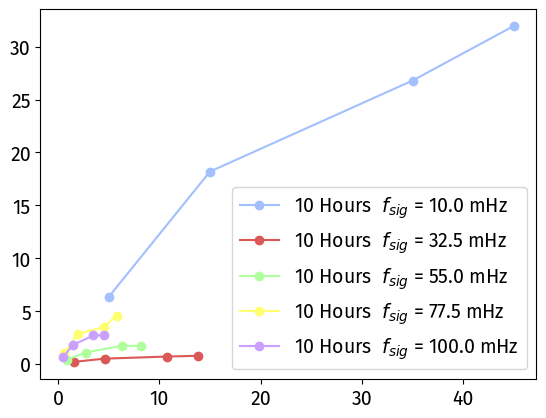

In [6]:
fs = np.linspace(0.01,0.1,5)
SNR_2d = []
for f in fs:

    phi = np.random.rand(1)*2*np.pi
    max_T = 1/(2*f)
    Ts = max_T*np.array([0.1,0.3,0.7,0.9])
    n_hours = 20
    T_total = n_hours*3600
    SNRs = []
    for T in Ts:
        t,phases,signals,phase_err = frequency_estimator_signal(T,T_total,f,phi)
        SNRs.append(snr_fft(signals, phases, 1/T, f, exclude_bw=5,plot = False))
    plt.plot(Ts,10**(np.array(SNRs)/10),'o-', label ='10 Hours  $f_{sig}$ = %0.1f mHz'%(f*1000) )
    SNR_2d.append(SNRs)
plt.legend()

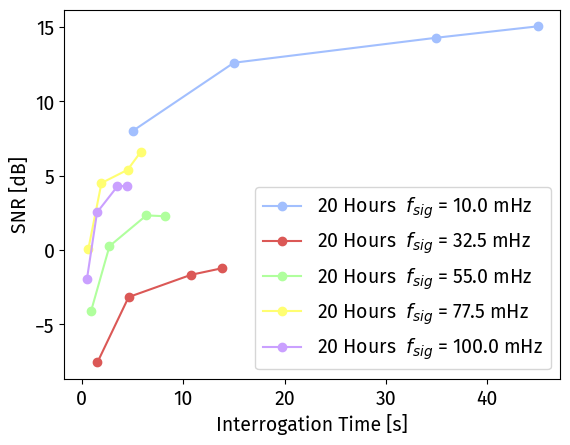

In [14]:
for f,SNRs in zip(fs,SNR_2d):
    max_T = 1/(2*f)
    Ts = max_T*np.array([0.1,0.3,0.7,0.9])
    plt.plot(Ts,np.array(SNRs),'o-', label ='20 Hours  $f_{sig}$ = %0.1f mHz'%(f*1000) )
    
plt.xlabel('Interrogation Time [s]')
plt.ylabel('SNR [dB]')
plt.legend()
plt.savefig('SNR_vs_T.pdf')

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

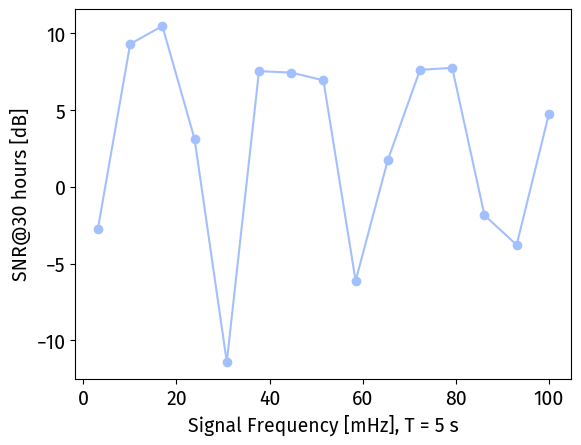

In [15]:
fs = np.linspace(1/320,0.1,15)
SNRs = []
for f in fs:

    phi = np.random.rand(1)*2*np.pi
    n_hours = 30
    T_total = n_hours*3600
    T = 5
    t,phases,signals,phase_err = frequency_estimator_signal(T,T_total,f,phi)
    SNRs.append(snr_fft(signals, phases, 1/T, f, exclude_bw=5,plot = False))
plt.plot(fs*1000,np.array(SNRs),'o-')
plt.xlabel('Signal Frequency [mHz], T = 5 s')
plt.ylabel('SNR@30 hours [dB]')
plt.savefig('SNR_vs_f.pdf')

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/2211 [00:00<?, ?it/s]

  0%|          | 0/3702 [00:00<?, ?it/s]

  0%|          | 0/5194 [00:00<?, ?it/s]

  0%|          | 0/6685 [00:00<?, ?it/s]

  0%|          | 0/8177 [00:00<?, ?it/s]

  0%|          | 0/9668 [00:00<?, ?it/s]

  0%|          | 0/11160 [00:00<?, ?it/s]

  0%|          | 0/12651 [00:00<?, ?it/s]

  0%|          | 0/14142 [00:00<?, ?it/s]

  0%|          | 0/15634 [00:00<?, ?it/s]

  0%|          | 0/17125 [00:00<?, ?it/s]

  0%|          | 0/18617 [00:00<?, ?it/s]

  0%|          | 0/20108 [00:00<?, ?it/s]

  0%|          | 0/21600 [00:00<?, ?it/s]

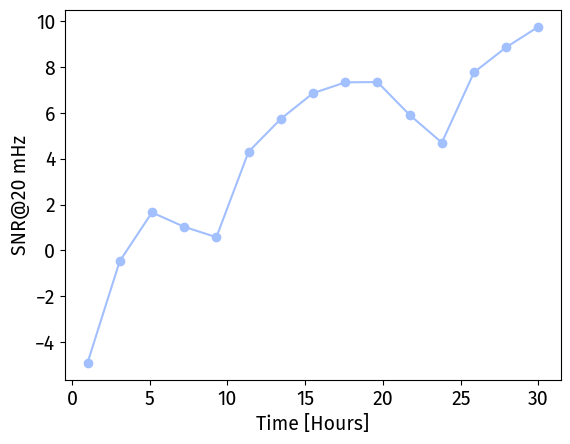

In [9]:
n_hours = np.linspace(1,30,15)
SNRs = []
for n in n_hours:

    phi = np.random.rand(1)*2*np.pi

    T_total = n*3600
    T = 5
    t,phases,signals,phase_err = frequency_estimator_signal(T,T_total,0.02,phi)
    SNRs.append(snr_fft(signals, phases, 1/T, 0.02, exclude_bw=5,plot = False))
plt.plot(n_hours,np.array(SNRs),'o-')
plt.xlabel('Time [Hours]')
plt.ylabel('SNR@20 mHz')
plt.savefig('SNR_vs_hours.pdf')

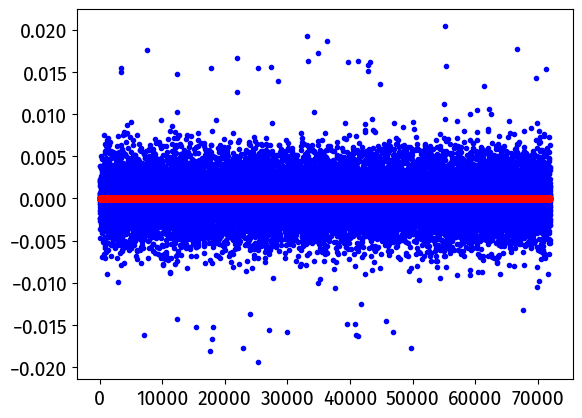

In [15]:
phases = np.array(phases)
signals = np.array(signals)
plt.plot(t,phases,'b.')
plt.plot(t,signals,'r.')

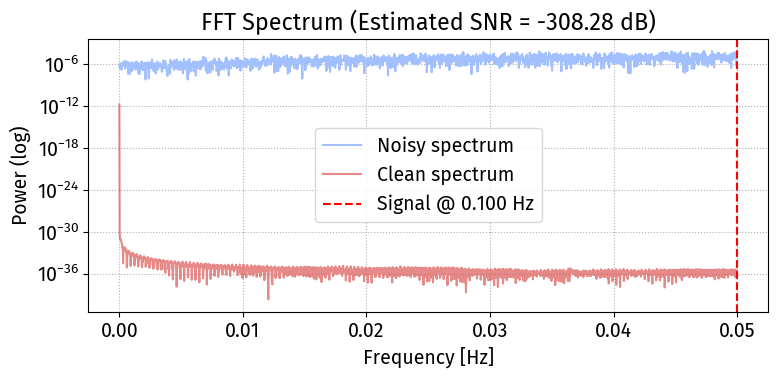

np.float64(-308.27962214700915)

In [33]:
snr_fft(signals, phases, 1/T, f, exclude_bw=5)

In [51]:
signals

array([ 7.85247286e-05,  1.64505182e-04, -2.89932136e-05, ...,
       -1.60787142e-04,  3.96067191e-05,  1.72712486e-04])

In [78]:
t,phases,signals,phase_err = frequency_estimator_signal(40,T_total,f,phi)


  0%|          | 0/900 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'shape'

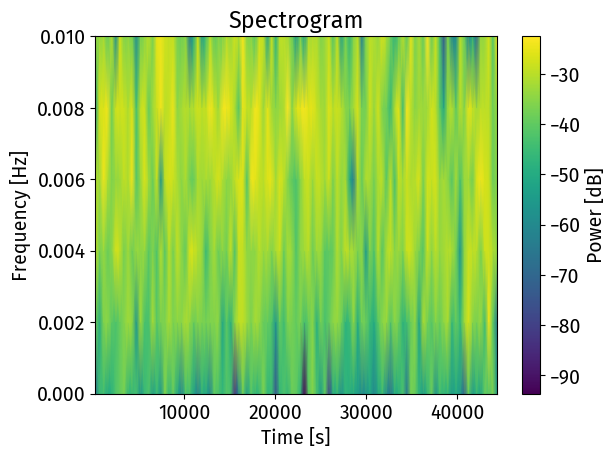

In [84]:
plot_spectrogram(np.array(s), 1/T, nperseg=10, noverlap=None, cmap="viridis", log_scale=True)